# Chapter 3: Learning Distributed Word Embeddings and Using Them for NLP

<p>In this notebook, you'll learn to load texts into Tensorflow by converting words to numbers. 
You'll learn how to train Latent Semantic Analysis (LSA) representations of words and documents using sklearn's TruncatedSVD method. You'll next train distributed word representations, also known as word embeddings, by 
building your first tensorflow neural network for NLP. You'll compare these word embeddings to similar representations
built with Latent Semantic Indexing (LSI). You'll learn how to save your embeddings for re-use, and how to load
pre-trained embeddings which you borrow from the cloud. Finally, you'll learn how to use pre-trained embeddings
for your first NLP task, categorizing documents. Along the way we'll point out many foundational techniques 
for NLP which will be helpful for you as your skills increase.</p>

## Table of Contents
(Internal Links)

## General Imports

In [1]:
import nltk
import sklearn
import numpy as np
from nltk.tokenize import word_tokenize
import os
import numpy as np
import tensorflow as tf
import gensim
import spacy

## Learn How to Load, Explore, and Preprocess Text Corpus

We'll use some of our own functions to explore the text of Moby Dick, before we start applying deep learning to it.
Tip: Make sure you've downloaded the NLTK text corpora following the directions at <a href="https://www.nltk.org/data.html">https://www.nltk.org/data.html</a>

### Tour of Toolsets to Prepare Data

#### NLTK

In [ ]:
#Let's use the text of Melville's novel Moby Dick as our corpus. We'll load it from the NLTK corpus library.
#Here's what the first couple sentences look like:
i = 0
for s in nltk.corpus.gutenberg.sents('melville-moby_dick.txt'):
    i += 1
    print(s)
    if i > 3:
        break

In [ ]:
#Find Melville's longest sentence.  Warning: it's long indeed!
longestLen = 0
longest = []
for s in nltk.corpus.gutenberg.sents('melville-moby_dick.txt'):
    thisLen = len(s)
    if thisLen > longestLen:
        longest = s
        longestLen = thisLen
print(longest)
print("Longest sentence length = {}".format(longestLen))

In [ ]:
#How about the longest word?
wlen = 0
longest = ''
for w in nltk.corpus.gutenberg.words('melville-moby_dick.txt'):
    if len(w) > wlen:
        longest = w
        wlen = len(w)
print(longest)

In [2]:
#Let's count how many unique words are in Moby Dick.
#We lower-case them first and remove punctuation. Here we're using the python string.lower() method and
#a home-rolled punctuation stripper to do this normalization. In other NLP tasks you'll do additional
#type of normalization including stripping non-ascii characters (pre-processing), stemming, and PoS tagging.
from nltk import FreqDist
from Chapter_03_utils import isPunctuation #Home-brewed function to test if token is punctuation

mobyDickWords = FreqDist(w.lower() for w in nltk.corpus.gutenberg.words('melville-moby_dick.txt') if ((isPunctuation(w) == False ) and (w not in nltk.corpus.stopwords.words('english'))))
print("There are {} word tokens in Moby Dick, of which {} are unique types.".format(len(nltk.corpus.gutenberg.words('melville-moby_dick.txt')),len(mobyDickWords)))
print("Most common words in Moby Dick excluding stop words:")
print("-" * 30)
print(mobyDickWords.most_common(10))


There are 260819 word tokens in Moby Dick, of which 17129 are unique types.
Most common words in Moby Dick excluding stop words:
------------------------------
[('i', 2124), ('whale', 1226), ('one', 921), ('the', 710), ('but', 705), ('like', 647), ('upon', 566), ('man', 527), ('ship', 518), ('ahab', 511)]


#### Gensim

In [ ]:
#Use gensim to get same results

texts = [[w.lower() for w in s if ((isPunctuation(w) == False ) and (w not in nltk.corpus.stopwords.words('english')))]  
                                               for s in nltk.corpus.gutenberg.sents('melville-moby_dick.txt')]
from collections import defaultdict #The nice thing about defaultdict objects is you don't have to initialize their values
frequencies = defaultdict(int)
for text in texts:
    for token in text:
        frequencies[token] += 1

In [ ]:
#Take advantage of the heapq structure to choose the words with highest counts
import heapq
print(heapq.nlargest(10, frequencies.items(), key=lambda x : x[1]))

In [ ]:
#Take advantage of gensim Dictionary object to make an efficient mapping between terms and integer ids
gensim_dictionary = gensim.corpora.Dictionary(texts)                                                                    
print("The dictionary has: " +str(len(gensim_dictionary)) + " tokens")

for (i, (k, v)) in enumerate(gensim_dictionary.token2id.items()):
     if i < 10:
        print(f'{k:{15}} {v:{10}}')

#### SpaCy

In [ ]:
#Peek into spaCy
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")

In [ ]:
raw_text = nltk.corpus.gutenberg.raw('melville-moby_dick.txt')[:100000]
doc = nlp(raw_text)

# Analyze syntax: examine most frequent verbs
verbFrequencies = defaultdict(int)
for token in doc:
    if token.pos_ == 'VERB':
        verbFrequencies[token.lemma_] += 1
print(heapq.nlargest(10, verbFrequencies.items(), key=lambda x : x[1]))

## Convert words to numbers
<i>This is the first step in preparing the text data to be fed into a neural network or other machine learning model.</i>

In [ ]:
#Explore bag-of-words vectors for the first few sentences of Moby Dick
sentences = [s for (i, s) in enumerate(nltk.corpus.gutenberg.sents('melville-moby_dick.txt')) if i in [2, 3]]
print(sentences)

In [ ]:
#Tabulate the vocabulary of this mini-corpus so we can use it to create the vectorizer
vocabulary_lists = [[w.lower() for w in s if isPunctuation(w) == False] for s in sentences]
vocabulary = set([item for sublist in vocabulary_lists for item in sublist])
print(vocabulary)

In [ ]:
#Vectorize using bag-of-words representations for each document
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(binary=True, tokenizer=lambda doc: doc, preprocessor=None, vocabulary=vocabulary, lowercase=False)
tdm = vectorizer.transform(vocabulary_lists)
print(tdm.shape)
print(vectorizer.get_feature_names())
print(tdm.todense()[0])

## Train Latent Semantic Index Word Representations from Corpus

Taking our inspiration from:
<a href="https://roshansanthosh.wordpress.com/2016/02/18/evaluating-term-and-document-similarity-using-latent-semantic-analysis/">Evaluating Term and Document Similarity Using Latent Semantic Analysis</a>

In [3]:
#Import some relevant packages
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
#Make termXdocument matrix from top 10000 words
vocab = [t for (t, f) in mobyDickWords.most_common(10000)]
print(vocab[:10])

['i', 'whale', 'one', 'the', 'but', 'like', 'upon', 'man', 'ship', 'ahab']


In [5]:
#Create a sparse vectorizer using TFIDF weights and the vocab list we just created
sparseVectorizer = TfidfVectorizer(vocabulary = vocab, tokenizer=lambda doc: doc, use_idf=True, lowercase=False)

In [6]:
#Start transforming Moby Dick from raw form into a corpus of documents we can feed into the TruncatedSVD
# fetch a list of sentences
sentences = [s for s in nltk.corpus.gutenberg.sents('melville-moby_dick.txt')]

In [7]:
# Preprocess: lowercase and remove punctuation
docs = [[w.lower() for w in s if isPunctuation(w) == False] for s in sentences]
print(docs[:2])

[['[', 'moby', 'dick', 'by', 'herman', 'melville', '1851', ']'], ['etymology']]


In [8]:
#Create the term X document matrix from the list of pre-processed sentences 
X = sparseVectorizer.fit_transform(docs)
print(X.shape)

(10059, 10000)


In [9]:
#Import sklearn pipeline class and Normalizer function
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
svd = TruncatedSVD(n_components = 100, algorithm="arpack")
lsa = make_pipeline(svd, Normalizer(copy=False))

In [10]:
#Reduce the dimensionality of the sparse matrix using LSA
lsa_X = lsa.fit_transform(X.T)
print(X.shape)
print(lsa_X.shape)

(10059, 10000)
(10000, 100)


In [11]:
def getClosestTerm(term,transformer,model):
 
    index = transformer.vocabulary_[term]      
 
    model = np.dot(model,model.T)
    searchSpace =np.concatenate( (model[index][:index] , model[index][(index+1):]) )  
 
    out = np.argmax(searchSpace)
 
    if out<index:
        return transformer.get_feature_names()[out]
    else:
        return transformer.get_feature_names()[(out+1)]
 

In [12]:
def kClosestTerms(k,term,transformer,model):
 
    index = transformer.vocabulary_[term]
 
    model = np.dot(model,model.T)
 
    closestTerms = {}
    for i in range(len(model)):
        if i != index:
            closestTerms[transformer.get_feature_names()[i]] = model[index][i]
 
    sortedList = sorted(closestTerms , key= lambda l : closestTerms[l], reverse=True)
    
    return(sortedList[:10])

In [14]:
#What has the LSA model learned about Ahab?
(kClosestTerms(8, 'ahab', sparseVectorizer, lsa_X))

['gritted',
 'advancing',
 'yelled',
 'cares',
 'unmindful',
 'loadstone',
 'slouched',
 'courageous',
 'enter',
 'parsee']

In [ ]:
print([d for d in docs if 'gritted' in d])

In [13]:
#What has the lsa model learned about whales?
kClosestTerms(8, 'whale', sparseVectorizer, lsa_X)

['wharton',
 'fossil',
 'icelandic',
 'sulphur',
 'sperm',
 'greenland',
 'indiscriminately',
 'cachalot',
 'tusked',
 'designated']

In [38]:
print(len([d for d in docs if 'animal' in d]))

17


## Train Deep Network for Word Embeddings
<i>Thanks to <a href="https://adventuresinmachinelearning.com/word2vec-keras-tutorial/">Adventures in Deep Learning's blog</a> for inspiring this section.</i>

### Specialized Imports

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, dot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.preprocessing import sequence
from Chapter_03_utils import build_dataset
from nltk import FreqDist, word_tokenize
from nltk.corpus import gutenberg #Corpus readers for various literary texts
from Chapter_03_utils import isPunctuation #Home-brewed function to test if token is punctuation
from Chapter_03_utils import SimilarityCallback

### Constants and Magic Numbers
To be used throughout the embeddings network training

In [19]:
vocabSize = 2000 #How many words should we include as input?  Top n-most frequent
windowSize = 3 #How many context words should be included on either side of the target word when choosing the skipgram pairs
vectorDim = 300 #How many dimensions are included in the embedding space
epochs = 10000 #Number of training epochs
evalSetSize = 16     # Random set of words to evaluate similarity on.
evalSetWindow = 100  # Only pick similarity evaluation samples from the head of the distribution (frequent terms).

In [20]:
#Function to build lexical resources for deep learning network
def collect_data(corpusName, vocabulary_size=10000):
    '''
    learn and return a list of integer codes corresponding to the words of the text,
    the term frequencies, and a regular and reverse dictionary of terms and integer codes.
    Modified from https://adventuresinmachinelearning.com/word2vec-keras-tutorial/
    '''
    #Retrieve the requested text from the NLTK corpora collections
    words = [w.lower() for w in nltk.corpus.gutenberg.words(corpusName) if isPunctuation(w) == False]
    print(words[:7])
    data, count, dictionary, reverse_dictionary = build_dataset(words,
                                                                vocabulary_size)
    del words  # Hint to reduce memory.
    return data, count, dictionary, reverse_dictionary

### Collect data from corpus, encode, build lexical resources

In [21]:
#Convert the raw text data into a list of integer codes, a frequency distribution of the terms, and a
# dictionary and reverse_dictionary of terms:integer_codes
data, count, dictionary, reverse_dictionary = collect_data('melville-moby_dick.txt', vocabulary_size=vocabSize)
print(data[:7])

['[', 'moby', 'dick', 'by', 'herman', 'melville', '1851']
[0, 280, 281, 23, 0, 0, 0]


In [22]:
#Choose n number of indices from the top m most frequent terms to use to test similarity at different points in the training
evalExamples = np.random.choice(evalSetWindow, evalSetSize, replace=False)

### Sample pairs of term-integer codes as skipgrams (target term, context term)

In [23]:
#Now build the list of skipgrams to use for training, both positive and negative examples
#Sampling frequencies for positive and negative skipgrams examples
sampling_table = sequence.make_sampling_table(vocabSize)
skipgramPairs, labels = skipgrams(data, vocabSize, window_size=windowSize, sampling_table=sampling_table)
word_target, word_context = zip(*skipgramPairs)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(skipgramPairs[:10], labels[:10])

[[65, 4], [892, 1328], [12, 6], [81, 35], [379, 1284], [730, 6], [993, 375], [1982, 57], [1627, 258], [1045, 1975]] [1, 0, 1, 1, 1, 1, 1, 1, 1, 0]


In [26]:
len([l for l in labels if l==0])

80699

In [77]:
#Substitute numbers found in the cell above
print(reverse_dictionary[25])
print(reverse_dictionary[883])

from
captains


In [78]:
print(reverse_dictionary[141])
print(reverse_dictionary[38])

look
they


In [41]:
#Reassure yourself that the labeling of the skipgrams is accurate
from Chapter_03_utils import is_Sublist
for s in nltk.corpus.gutenberg.sents('melville-moby_dick.txt'):
    if is_Sublist(s, ['they', 'look'])==True:
        print(s)

['As', 'it', 'is', ',', 'parts', 'of', 'her', 'back', 'country', 'are', 'enough', 'to', 'frighten', 'one', ',', 'they', 'look', 'so', 'bony', '.']
['"', 'I', 'look', ',', 'you', 'look', ',', 'he', 'looks', ';', 'we', 'look', ',', 'ye', 'look', ',', 'they', 'look', '."']
['"', 'I', 'look', ',', 'you', 'look', ',', 'he', 'looks', ';', 'we', 'look', ',', 'ye', 'look', ',', 'they', 'look', '."']
['"', 'I', 'look', ',', 'you', 'look', ',', 'he', 'looks', ';', 'we', 'look', ',', 'ye', 'look', ',', 'they', 'look', '."']


### Define and build input layers using tf.keras functional API

<p>We're doing several tricky things here.  First, we're using the tf.keras functional api to define our model because we have two separate input laters, so the standard Sequential() api won't work for us. We instantiate each layer as a fucntion call whose argument is the list of layers feeding it.</p>
<p>Secondly we define a separate model -- the similarityModel -- which we don't compile and train separately. We just hook it up to our SimilarityCallback function, so we can test word similarity at different points during the training to see how much our network has learned.</p>

In [27]:
# create 2 input layers with one input node each, for the skipgram target and context word codes
input_target = Input((1,), name="input_target")
input_context = Input((1,), name="input_context")

In [28]:
#Create the embedding layer and two lookup layers for target and context
embedding = Embedding(vocabSize, vectorDim, input_length=1, name='embedding')
target = embedding(input_target)
reshaped_target = Reshape((vectorDim, 1), name="reshaped_target_embedding")(target)
context = embedding(input_context)
reshaped_context = Reshape((vectorDim, 1), name="reshaped_context_embedding")(context)

In [29]:
# Define cosine similarity operation which will be output in a secondary model
similarity = dot([reshaped_target, reshaped_context], axes=1, normalize=True)

In [30]:
# Create dot product layer for main model to get a similarity measure between target embedding and context embedding
dot_product = dot([reshaped_target, reshaped_context], axes=1, normalize=False, name="dot_product")
reshaped_dot_product = Reshape((1,), name="reshaped_dot_product")(dot_product)

In [31]:
# add the sigmoid output layer
output = Dense(1, activation='sigmoid', name="output")(reshaped_dot_product)

In [32]:
# create the primary training model
learningModel = Model(inputs=[input_target, input_context], outputs=output, name="learningModel")
learningModel.compile(loss='binary_crossentropy', optimizer='adam')

In [33]:
# create a secondary validation model to run our similarity checks during training
similarityModel = Model(inputs=[input_target, input_context], outputs=similarity, name="similarityModel")
sim_cb = SimilarityCallback()

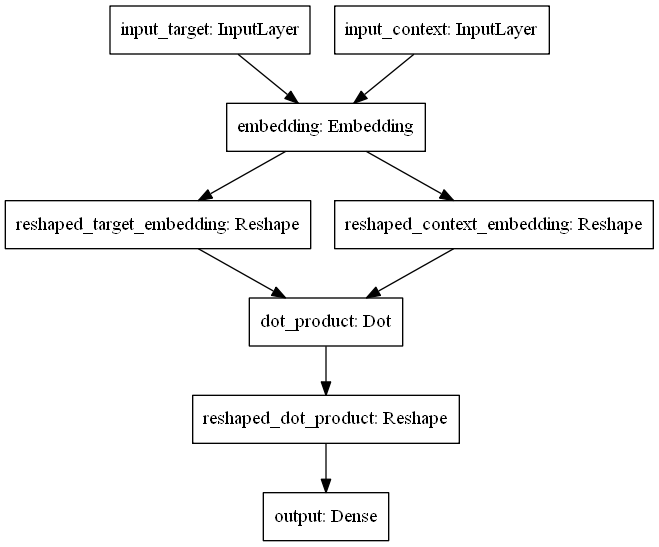

In [34]:
#Tip: Make sure you install pyplot and graphviz before attempting this step
from tensorflow.keras.utils import plot_model
plot_model(learningModel, to_file='model.png')

### Train Network with Skipgram Samples from Corpus

In [99]:
#Finally, train the learning model, evaluating word similarity at specified epochs
history = [] #Store loss for plotting
arr_1 = np.zeros((1,))
arr_2 = np.zeros((1,))
arr_3 = np.zeros((1,))
for cnt in range(epochs):
       
    idx = np.random.randint(0, len(labels)-1)
    arr_1[0,] = word_target[idx]
    arr_2[0,] = word_context[idx]
    arr_3[0,] = labels[idx]

    loss = learningModel.train_on_batch([arr_1, arr_2], arr_3)
  
    if cnt % 100 == 0:
        print("Iteration {}, loss={}".format(cnt, loss))
        history.append((cnt, loss))
    if cnt in [0, (epochs - 1)]:
        for testWord in ['ahab', 'whale', 'harpoon', 'boy', 'coffin']:
            sim_cb.probe_word(testWord, dictionary, reverse_dictionary, vocabSize, similarityModel)
        sim_cb.run_sim(evalSetSize, evalExamples, reverse_dictionary, vocabSize, similarityModel)

Iteration 0, loss=0.7088454961776733
Nearest to ahab: narrative, experienced, rushing, pull, huge, thin, indian, i,
Nearest to whale: mountains, fly, old, thrown, manner, this, object, pictures,
Nearest to harpoon: though, crews, than, oceans, like, dangerous, covered, sight,
Nearest to boy: waist, instead, mouth, swallow, forget, owners, are, felt,
Nearest to coffin: shoulders, held, wanting, yet, cases, forget, breath, often,
Nearest to captain: north, utmost, otherwise, news, account, fitted, fish, joy,
Nearest to t: keel, always, indispensable, objects, passing, invariably, how, beholding,
Nearest to it: moment, any, over, bearing, death, early, an, prodigious,
Nearest to him: boiling, bildad, fate, piled, wrinkles, awe, nay, born,
Nearest to for: belong, regularly, smoking, dat, darting, drowned, held, striking,
Nearest to very: hump, coat, consider, placed, leap, tongue, look, while,
Nearest to there: canoe, bulk, mean, directly, fashioned, lighted, madness, swift,
Nearest to oth

## Examine What the Network Has Learned

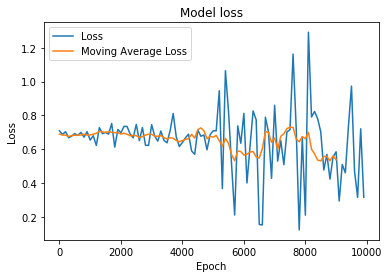

In [133]:
# Plot training & validation loss values

import matplotlib.pyplot as plt
N = 10
losses = [l for (e,l) in history]
epochs = [e for (e,l) in history]
ma_epochs = [np.arange(0,9100, 100)]
mae = np.reshape(ma_epochs, (91,))
loss_line = plt.plot(epochs, losses)
#Also plot the moving average, to show the trend more clearly
mae_line = plt.plot(mae, np.convolve(losses, np.ones((N,))/N, mode='valid'))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(labels = ['Loss', 'Moving Average Loss'])
#plt.show()
plt.savefig('loss_plot.png')

<Figure size 432x288 with 0 Axes>

In [101]:
sim_cb.probe_word('whale', dictionary, reverse_dictionary, vocabSize, similarityModel)

Nearest to whale: right, seas, ahab, the, large, animal, way, than,


## Compare LSI Word Representations to Deep Learning Embeddings

## Save Trained Embeddings for Later Use

## Load Pre-Trained Embeddings

## Load Corpus of Categorized Documents

## Define Deep Network to Categorize Documents Using Pre-Trained Embeddings

## Train Network, Test Accuracy on Hold-out Set